In [1]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
import torch
import random
import shutil

/tmp/ipykernel_124487/1862217413.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Constants
DATASET_DIR = 'data'
RATIO = [0.75,0.15,0.15]
SEED = 0

In [3]:
# Set Seed 
def set_seed(seed_value):
    """
    Set seed for reproducibility.
    """
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # for multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    random.seed(seed_value)
    
def check_and_create_directory(path):
    """Check if a directory exists at the specified path, and create it if it doesn't exist."""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Directory created at: {path}")
    else:
        print(f"Directory already exists at: {path}")
    return path

set_seed(SEED)

In [4]:
# Stratify and Create Train/Val/Test Directories for the Dataset
def organize_dataset(dataset_path:str,ratio:list=[0.75,0.15,0.15],seed:int=0,tag:str='UAV'):
    images_path = os.path.join(dataset_path, "image")
    labels_path = os.path.join(dataset_path, "label")
    
    # List the files
    image_files = os.listdir(images_path)
    label_files = os.listdir(labels_path)
    
    # Assuming filenames without extension match between images and labels
    base_filenames = [os.path.splitext(file)[0] for file in image_files]

    # Create a DataFrame
    df = pd.DataFrame(base_filenames, columns=['filename'])    
    train_val, test = train_test_split(df, test_size=ratio[2], random_state=seed)
    train, val = train_test_split(train_val, test_size=ratio[1], random_state=seed)  # 0.25 x 0.8 = 0.2

    # Function to move files into train/val/test structure
    def arrange_dataset(df, subset_name):
        save_path = check_and_create_directory(os.path.join(dataset_path,tag))
        subset_path = os.path.join(save_path, subset_name)
        os.makedirs(subset_path, exist_ok=True)
        for filename in df['filename']:
            image_src = os.path.join(images_path, filename + '.jpg')
            label_src = os.path.join(labels_path, filename + '.txt')
            
            # Create subset folders for images and labels
            os.makedirs(os.path.join(subset_path, 'images'), exist_ok=True)
            os.makedirs(os.path.join(subset_path, 'labels'), exist_ok=True)
        
            # Copy files
            shutil.copy(image_src, os.path.join(subset_path, 'images', filename + '.jpg'))
            shutil.copy(label_src, os.path.join(subset_path, 'labels', filename + '.txt'))
            
            
        return os.listdir(os.path.join(subset_path,'images')),os.listdir(os.path.join(subset_path,'images'))
            
    # Organize the dataset
    train_images, train_labels = arrange_dataset(train, 'train')
    val_images, val_labels =arrange_dataset(val, 'val')
    test_images, test_labels =arrange_dataset(test, 'test')
    
    return (train_images,train_labels),(val_images,val_labels),(test_images,test_labels),os.path.join(dataset_path,tag)


In [5]:
train_dataset, val_dataset, test_dataset,data_path = organize_dataset(
    dataset_path=DATASET_DIR,
    ratio=RATIO,
    seed=SEED,
    tag='UAV_DATASET'
)

print('[INFO] Train Dataset Len : ',len(train_dataset[0]))
print('[INFO] Val Dataset Len : ',len(val_dataset[0]))
print('[INFO] Test Dataset Len : ',len(test_dataset[0]))

Directory already exists at: data/UAV_DATASET
Directory already exists at: data/UAV_DATASET
Directory already exists at: data/UAV_DATASET
[INFO] Train Dataset Len :  226
[INFO] Val Dataset Len :  40
[INFO] Test Dataset Len :  48


In [6]:

def plot_images_with_labels(subset_path, n=12, rows=3, cols=4,normalized=False):
    images_dir = os.path.join(subset_path, 'images')
    labels_dir = os.path.join(subset_path, 'labels')

    # Get list of files
    all_images = os.listdir(images_dir)
    
    # Randomly select n images
    selected_images = random.sample(all_images, n)
    
    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
    fig.subplots_adjust(hspace = .5, wspace=.05)
    axs = axs.ravel()
    
    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(images_dir, img_file)
        label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt')
        
        # Load image
        img = Image.open(img_path)
        axs[i].imshow(img)
        
        # Load labels
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.split()
                    class_id, x, y, width, height = map(float, parts[:5]) # Coordinates are in pixel format
                    if normalized:
                        x = (x - width / 2) * img.width
                        y = (y - height / 2) * img.height
                        width *= img.width
                        height *= img.height
                    
                    # Create a Rectangle patch
                    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
                    
                    # Add the patch to the Axes
                    axs[i].add_patch(rect)
                    
        # axs[i].set_title('Image: ' + img_file)
        axs[i].axis('off')

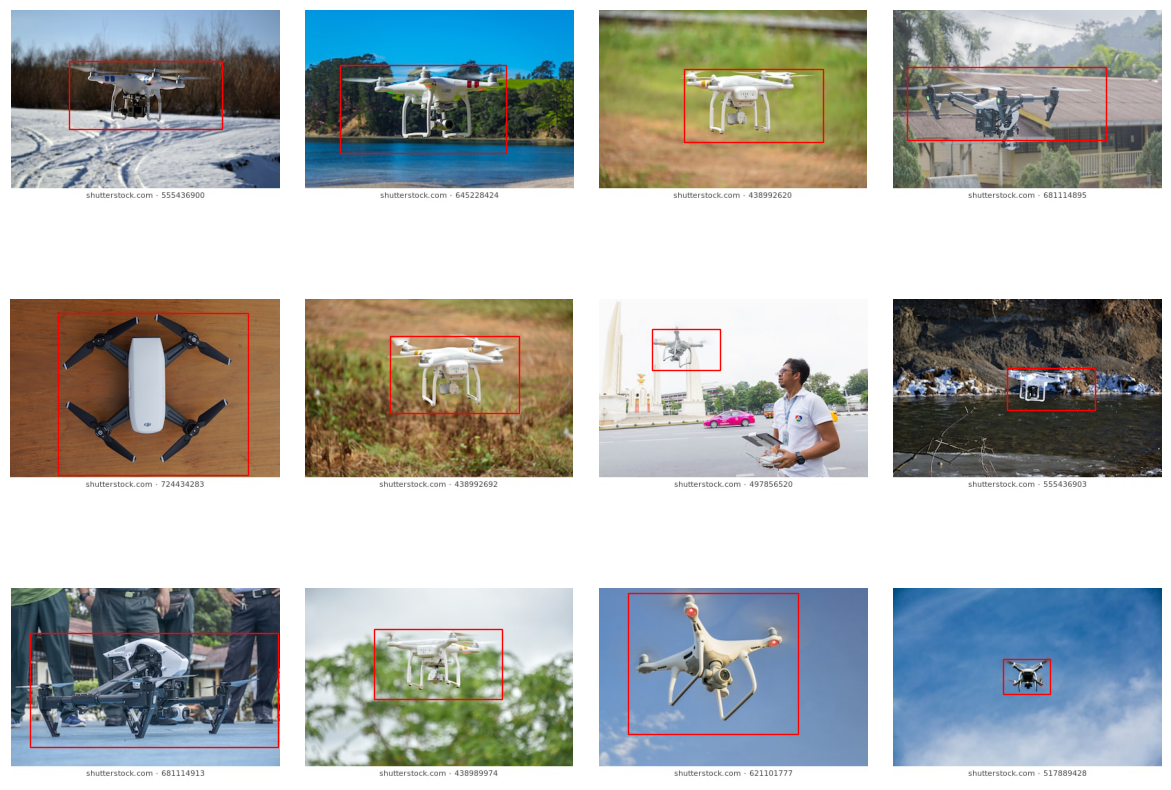

In [7]:
# Example usage
plot_images_with_labels(os.path.join(data_path,'train'), n=12)
plt.show()


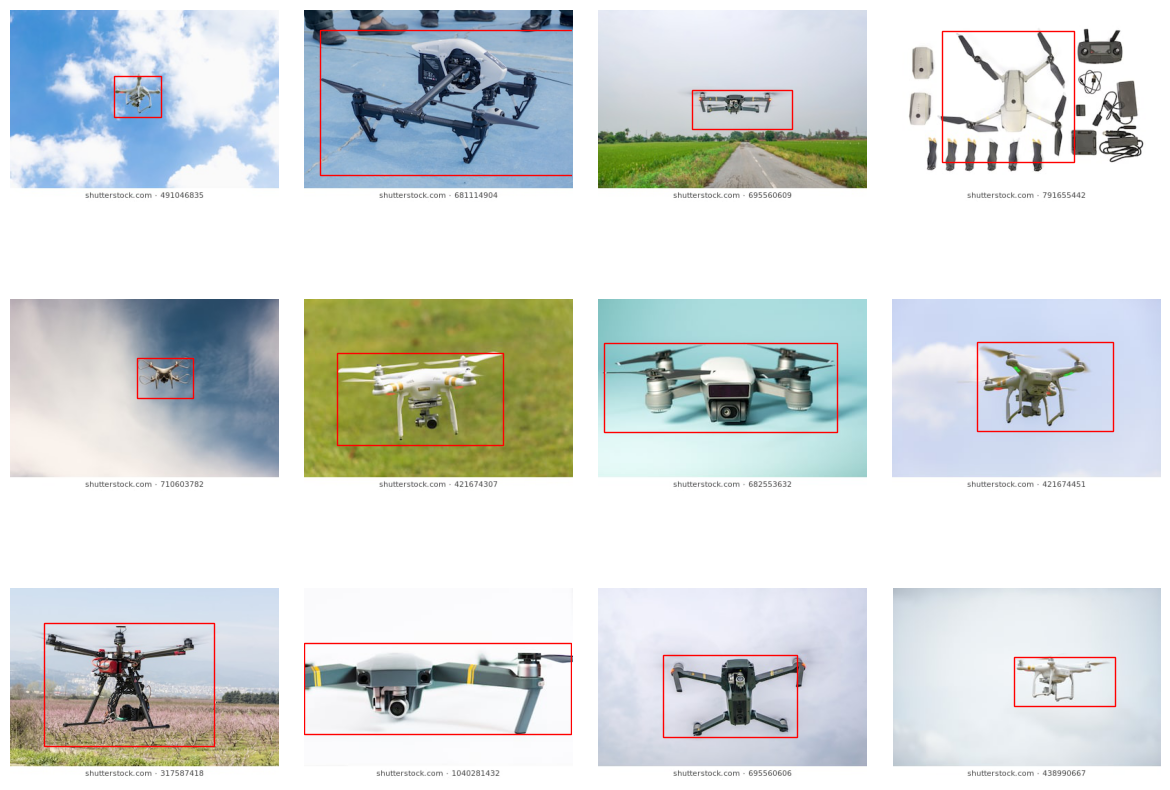

In [8]:
# Example usage
plot_images_with_labels(os.path.join(data_path,'val'), n=12)
plt.show()


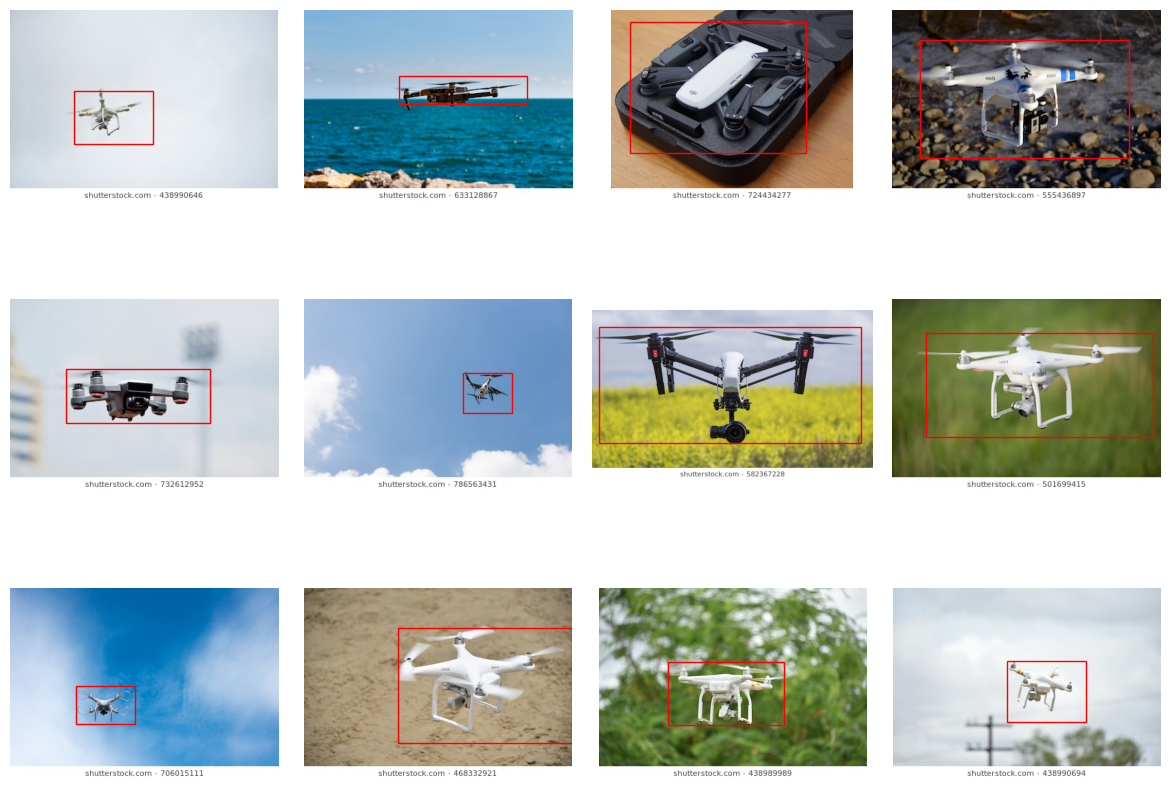

In [9]:
# Example usage
plot_images_with_labels(os.path.join(data_path,'test'), n=12)
plt.show()


## Preprocessing

In [10]:
# Resize the Images and Save by Keeping the Aspect Ratio 
# Normalize the Labels after rescaling 
def resize_and_adjust_labels(subset_path, target_size=(416, 416)):
    images_dir = os.path.join(subset_path, 'images')
    labels_dir = os.path.join(subset_path, 'labels')

    image_files = os.listdir(images_dir)

    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)
        label_file = image_file.replace('.jpg', '.txt')
        label_path = os.path.join(labels_dir, label_file)

        # Open and resize image
        with Image.open(image_path) as img:
            original_size = img.size  # Original size
            img_resized = img.resize(target_size, Image.LANCZOS) # maintains the aspect ratio
            img_resized.save(image_path)  # Save resized image

        # If corresponding label exists, adjust bounding box coordinates
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                lines = file.readlines()

            with open(label_path, 'w') as file:
                for line in lines:
                    parts = line.split()
                    class_id, x_min, y_min, bbox_width, bbox_height = map(float, parts[:5])

                    # Rescale bounding boxes to match the resized image
                    x_min_rescaled = (x_min / original_size[0]) * target_size[0]
                    y_min_rescaled = (y_min / original_size[1]) * target_size[1]
                    width_rescaled = (bbox_width / original_size[0]) * target_size[0]
                    height_rescaled = (bbox_height / original_size[1]) * target_size[1]

                    # Normalize the coordinates
                    x_center_normalized = (x_min_rescaled + width_rescaled / 2) / target_size[0]
                    y_center_normalized = (y_min_rescaled + height_rescaled / 2) / target_size[1]
                    width_normalized = width_rescaled / target_size[0]
                    height_normalized = height_rescaled / target_size[1]

                    # Write normalized coordinates back to file
                    file.write(f"{int(class_id)} {x_center_normalized} {y_center_normalized} {width_normalized} {height_normalized}\n")


In [11]:
resize_and_adjust_labels(os.path.join(data_path,'train'))
resize_and_adjust_labels(os.path.join(data_path,'val'))
resize_and_adjust_labels(os.path.join(data_path,'test'))

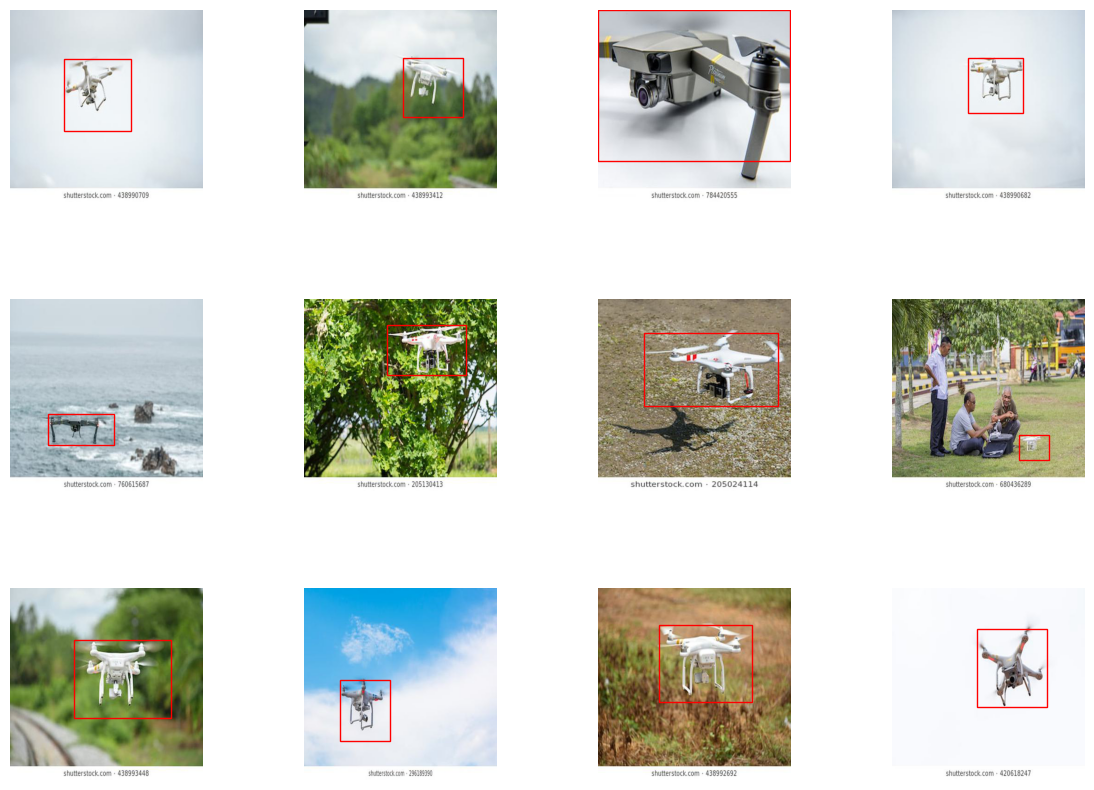

In [12]:
# verify the preprocessing done has not affected the groundtruth 
plot_images_with_labels(os.path.join(data_path,'train'), n=12,normalized=True)
plt.show()


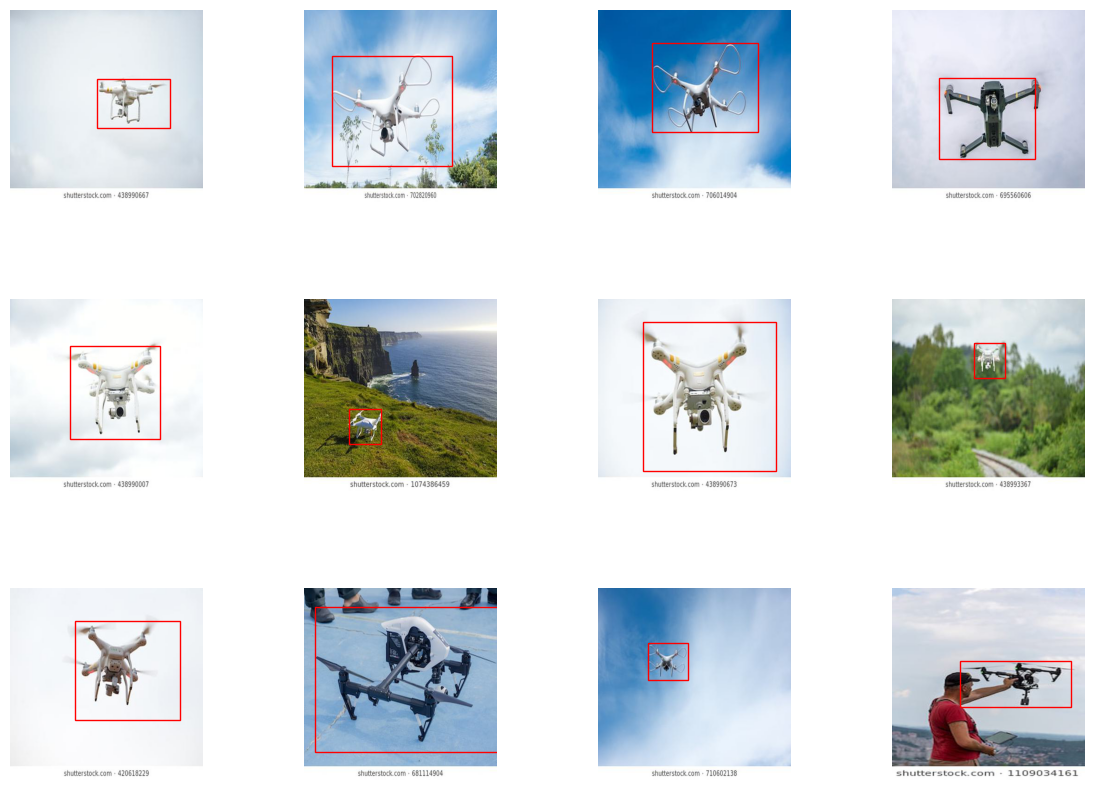

In [13]:
# verify the preprocessing done has not affected the groundtruth 
plot_images_with_labels(os.path.join(data_path,'val'), n=12,normalized=True)
plt.show()


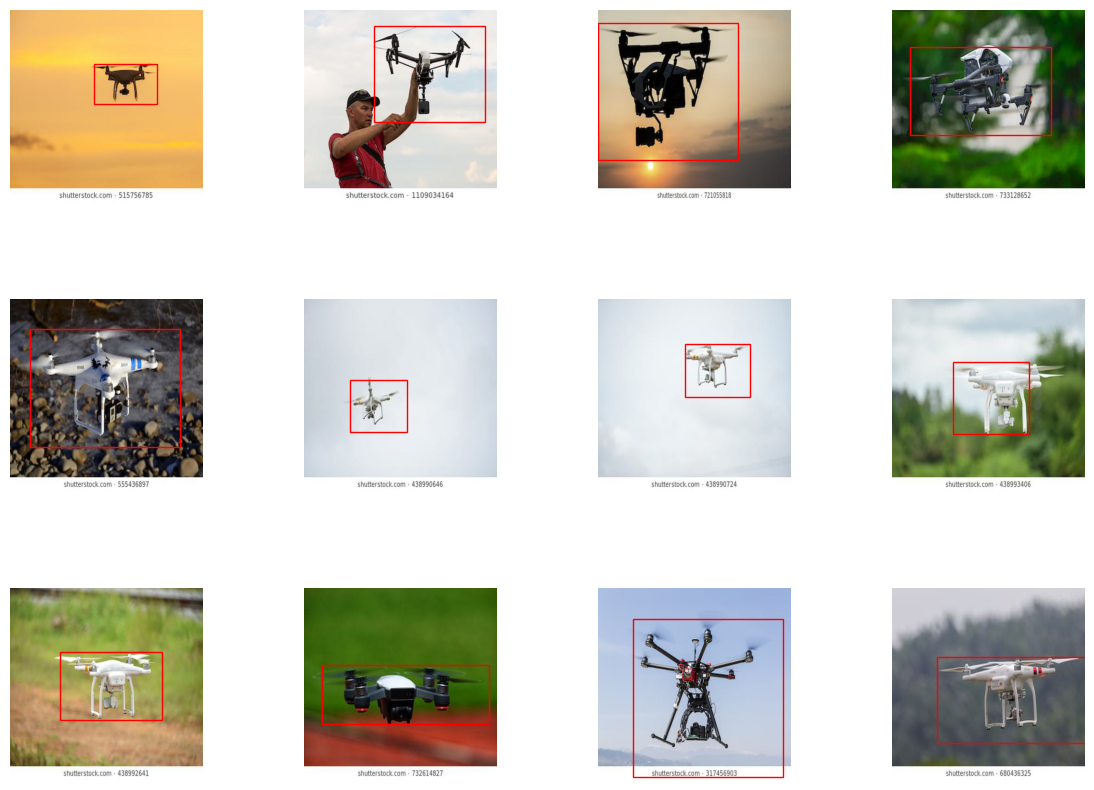

In [14]:
# verify the preprocessing done has not affected the groundtruth 
plot_images_with_labels(os.path.join(data_path,'test'), n=12,normalized=True)
plt.show()
